# Machine Learning Project #3 - Elia Perantoni

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.patches as mpatches
from scipy.stats import multivariate_normal

plt.style.use("seaborn-bright")

In [2]:
train = pd.read_csv("train.csv")
# Remove 'subject' column because not interesting for our goal
train.drop(["subject"], axis="columns", inplace=True)

In [3]:
train_X = train.drop(["Activity"], axis="columns").values
train_y = train["Activity"].values

# n is the number of training samples
# d is the number of features
n, d = train_X.shape
assert n == train_y.size

print(f"train_X is {n} x {d} dimensional ({n} vectors of {d} features each)")
print(f"train_y is {n} dimensional")

train_X is 7352 x 561 dimensional (7352 vectors of 561 features each)
train_y is 7352 dimensional


In [4]:
# Maps string labels to ints and vice-versa
class ClassMapper:
    def __init__(self, y):
        self.from_int = list(set(y))
        self.to_int = {label: idx for idx, label in enumerate(self.from_int)}

    def transform(self, y):
        return np.vectorize(lambda y_prime: self.to_int[y_prime])(y)


# train_y is ["WALKING", "STANDING", "WALKING", ... ]
cm = ClassMapper(train_y)
train_y = cm.transform(train_y)
# train_y is [0, 1, 0, ... ]

After PCA dimensionality reduction, train_X is 7352 x 168 dimensional (7352 vectors of 168 features each)


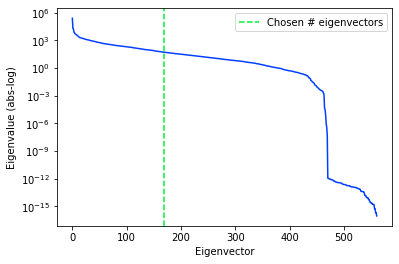

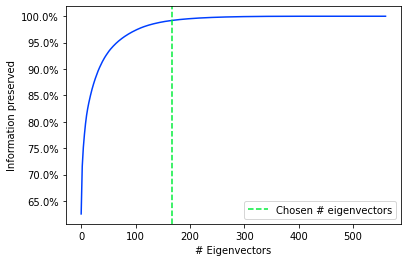

In [5]:
## PCA
def pca(X: np.ndarray, retain=0.3, verbose=False):
    """
    Performs Principal Component Analysis on X and returns the projected matrix
    :param X: The matrix to perform PCA on
    :param retain: The ratio of features to retain. i.e. 0.1 means project on the top 10% features
    :param verbose: Print and plot additional information
    """

    _, d = X.shape

    μ = np.mean(X, axis=0)
    # Subtract the mean
    Xc = X - μ
    # Compute scatter matrix
    S = Xc.T @ Xc

    eig_vals, eig_vecs = np.linalg.eig(S)
    # The eigenvalues and eigenvectors may have tiny imaginary parts due to numerical errors
    eig_vals, eig_vecs = eig_vals.real, eig_vecs.real

    # Sorting
    idx = np.argsort(abs(eig_vals))[::-1]
    eig_vals, eig_vecs = eig_vals[idx], eig_vecs[:, idx]

    # How many eigenvalues to take
    k = int(d * retain)

    if verbose:
        ax = plt.figure().gca()
        ax.xaxis.get_major_locator().set_params(integer=True)

        plt.plot(np.arange(d), abs(eig_vals))
        plt.axvline(x=k, c="C1", linestyle="--", label="Chosen # eigenvectors")
        plt.yscale("log")
        plt.xlabel("Eigenvector")
        plt.ylabel("Eigenvalue (abs-log)")
        plt.legend()

        plt.savefig("report/img/pca_1", dpi=150)

        ax = plt.figure().gca()
        ax.xaxis.get_major_locator().set_params(integer=True)
        ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))

        plt.plot(np.arange(d), abs(eig_vals).cumsum() / abs(eig_vals).sum())
        plt.axvline(x=k, c="C1", linestyle="--", label="Chosen # eigenvectors")
        plt.xlabel("# Eigenvectors")
        plt.ylabel("Information preserved")
        plt.legend()

        plt.savefig("report/img/pca_2", dpi=150)

    # Take only the first k eigenvalues
    idx = idx[:k]
    eig_vals, eig_vecs = eig_vals[idx], eig_vecs[:, idx]

    def project(X):
        return X @ eig_vecs

    return project


pca_reduce = pca(train_X, verbose=True)

train_X = pca_reduce(train_X)
_, d = train_X.shape
print(f"After PCA dimensionality reduction, train_X is {n} x {d} dimensional ({n} vectors of {d} features each)")

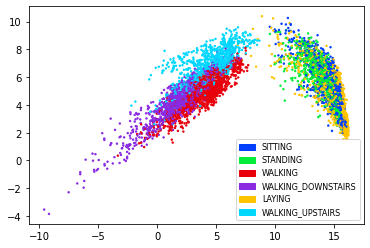

In [6]:
# PCA helps to reduce the number of features but the classes are still not perfectly separable.
plt.figure()
plt.scatter(
    train_X[:, 0],
    train_X[:, 1],
    c=[f"C{y_prime}" for y_prime in train_y],
    s=2,
)
plt.legend(handles=[
    mpatches.Patch(color=f"C{i}", label=label) for i, label in enumerate(cm.from_int)
], prop={"size": 8})

plt.savefig("report/img/pca_3", dpi=150)

## LDA

After LDA dimensionality reduction, train_X is 7352 x 5 dimensional (7352 vectors of 5 features each)


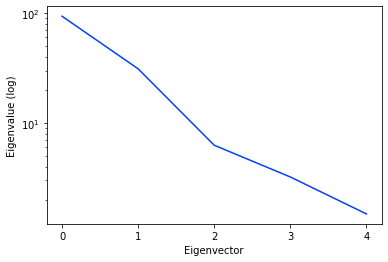

In [7]:
def lda(X: np.ndarray, y: np.ndarray, verbose=False):
    n, d = X.shape
    assert n == y.size

    classes = np.unique(y)

    # Global mean
    μ = np.mean(X, axis=0)

    # Within class scatter matrix
    Sw = np.zeros((d, d))
    # Between class scatter matrix
    Sb = np.zeros((d, d))

    for i in classes:
        # Mean for i-th class
        μi = np.mean(X[y == i], axis=0)

        Sw += (X[y == i] - μi).T @ (X[y == i] - μi)

        # Number of samples in the i-th class
        Ni = (y == i).sum()
        Sb += Ni * ((μi - μ)[np.newaxis].T @ (μi - μ)[np.newaxis])

    eig_vals, eig_vecs = np.linalg.eig(np.linalg.inv(Sw) @ Sb)
    # The eigenvalues and eigenvectors may have tiny imaginary parts due to numerical errors
    eig_vals, eig_vecs = eig_vals.real, eig_vecs.real

    # Sorting
    idx = np.argsort(abs(eig_vals))[::-1]
    eig_vals, eig_vecs = eig_vals[idx], eig_vecs[:, idx]

    # Take only the first k-1 eigenvalues
    idx = idx[:len(classes) - 1]
    eig_vals, eig_vecs = eig_vals[idx], eig_vecs[:, idx]

    if verbose:
        ax = plt.figure().gca()
        ax.xaxis.get_major_locator().set_params(integer=True)

        plt.plot(np.arange(len(classes) - 1), eig_vals)
        plt.yscale("log")
        plt.xlabel("Eigenvector")
        plt.ylabel("Eigenvalue (log)")

    def project(X):
        return X @ eig_vecs

    return project


lda_reduce = lda(train_X, train_y, verbose=True)

train_X = lda_reduce(train_X)
_, d = train_X.shape
print(f"After LDA dimensionality reduction, train_X is {n} x {d} dimensional ({n} vectors of {d} features each)")

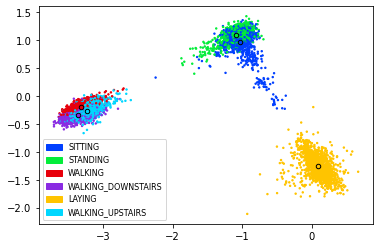

In [8]:
# After projecting using LDA, the 1st and 4th feature separate the data really neatly!
scatter_y1 = 0
scatter_y2 = 1

plt.figure()
plt.scatter(
    train_X[:, scatter_y1],
    train_X[:, scatter_y2],
    c=[f"C{y_prime}" for y_prime in train_y],
    s=2,
)
plt.legend(handles=[
    mpatches.Patch(color=f"C{i}", label=label) for i, label in enumerate(cm.from_int)
], prop={"size": 8})

for i in np.unique(train_y):
    μi = np.mean(train_X[train_y == i], axis=0)
    plt.scatter(μi[scatter_y1], μi[scatter_y2], c=f"C{i}", edgecolors="black", s=20)

plt.savefig("report/img/lda_1", dpi=150)

In [9]:
class Blob:
    def __init__(self, X):
        self.μ = np.mean(X, axis=0)
        # Estimate the covariance matrix
        self.Σ = 1 / X.shape[0] * ((X - self.μ).T @ (X - self.μ))

        # Will get assigned later
        self.prior = None

    def likelihood(self, x):
        return multivariate_normal.pdf(x, mean=self.μ, cov=self.Σ)

    def set_prior(self, prior):
        self.prior = prior


blobs = {}

for class_ in np.unique(train_y):
    blob = Blob(train_X[class_ == train_y])
    blob.set_prior((class_ == train_y).sum() / train_y.size)
    blobs[class_] = blob

In [10]:
test = pd.read_csv("test.csv")
# Remove 'subject' column because not interesting for our goal
test.drop(["subject"], axis="columns", inplace=True)
test_X = test.drop(["Activity"], axis="columns").values
test_y = test["Activity"].values

# Convert classes to integers
test_y = cm.transform(test_y)

# Apply the same PCA and LDA transformations that we did on the training set
test_X = lda_reduce(pca_reduce(test_X))

assert test_X.shape[0] == test_y.size

# How many samples from the testing set did we predict correctly
correct = 0

for i in range(test_X.shape[0]):
    x, y = test_X[i], test_y[i]

    # The winning class is the one that returns the maximum posterior (the evidence can be ignored)
    predicted = max(blobs.items(), key=lambda e: e[1].likelihood(x) * e[1].prior)[0]
    if predicted == y:
        correct += 1

print(f"Accuracy is {correct / test_y.size:.20f}")

Accuracy is 0.96131659314557171836
